## The Problem

Bellhops is a startup moving company that contracts movers and truck drivers to provide a high-quality, on-demand moving experience.  One of the company's logistical challenges is figuring out for how long a move should be scheduled. The company does not want to ovestimate how long a move will take because that could deter customers from booking, and if they do book, overestimating will unessesarily tie up resources. The company does not want to underestimate move length because if a move goes over the estimated time, it can cause a back up throughout the rest of the day.

Bellhops has two main move types, or "broad move types": Full Service (FS) and Labor Only (LO.) On LO moves, Bellhops only provides movers, typically 2-3. On FS moves, Bellhops provides a truck and usually 2-4 movers. Generally speaking, for a given move, the more movers that work, the shorter the time between start and finish, or "move length." Because drivers are paid a higher hourly rate than movers, stacking several shorter moves with more movers is more economical than scheduling longer moves with fewer movers. In general, Bellhops would like to schedule moves so they are completed in under three hours. This would let Bellhops schedule a driver on 3 moves a day. However, as things stand 70% of FS moves are scheduled with 2 movers and roughly 50% of FS moves last longer than 3 hours. 

In addition to descreasing driver related costs, Bellhops has found that for a given number of man hours worked, the average NPS is 20% higher and there are 50% fewer poor experience discounts on 3-mover jobs vs. 2 mover jobs. (Please note this is observational data, rather than experimental.) 

If Bellhops could better predict whether or not a move was going to exceed the three-hour mark, Bellhops could simply schedule more movers, thereby increasing the company's bottom line and potentially improving the customer experience.

## Data

The data come from Bellhops’ internal data warehouse. For each move the company performs, it collects the following features:

Order Id - the internal id for the move

Move Length Hours - the time between move start and finish (reservation start and the last clock out)

Executed Man Hours - the number of man hours it took to complete the move (roughly the number of movers times the move length)

Order Total Spots - the number of movers that worked on the order

Booked Man Hours - the number of man hours that were booked

Market - the city in which the move took place

FS - whether or not the move was a "Full Service" move, a move for which bellhops provided a driver and a truck. These are almost always multi-location moves. Non-full service moves are "Labor Only," moves where bellhops only provides labor. Labor only moves can be single or multication. Full Service and Labor Only are the two "Broad Move Types."

Move Type - a move specific type of move. Can be Full Service or one of the following Labor Only move Types: A to B, In House Labor, Loading, Unloading

House - whether or not the property type was a house

Residence - whether or not the property was a residence

Rooms - the number of rooms on the property

Coupon Amount - the value of the customer's coupon, if present

Phone - dummy variable equals one when the move was booked on the phone and zero when booked online

GRPN - whether or not the move was from Groupon

Reservation Start - the datetime at which the reservation was scheduled to start

Booked At - the datetime at which the order was booked

Dense - whether or not the order occurred in a market with more than 10k people per sq. mile

Flights of Stairs - the total number of flights of stairs for all properties on the move

Stops - the number of locations on the move

Elevators - the number of elevators reported during the booking porcess

Additional Instructions - whether or not the customer reported additional instructions during the booking process

Num Effort Hops - the number of hops that previousely received poor effort ratings from customers

Num Bad Star Hops - the number of hops on the job with previous low overall reviews

Avg Prev Late Rate - the average of the movers' rates of being late on previous moves

Sum Prev Late Rate - the sum of the movers' rates of being late on previous moves

Max Late Clock In Hours - the latest any mover was to the move in hours

Sum Late Clock In Hours - the total number of man hours that movers were late to the move

City Pop - the population of the market

Pop Density - the population density of the market

## Data Cleaning

#### Set Up
First, I imported pandas so I could work with this data as a DataFrame. I imported numpy and datetime for feature engineering. I read the csv into a pandas DataFrame, with column ‘order_id’ as the index. 


In [59]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import date

#Read csv into a pandas dataframe.
csv = 'move_length.csv'
df = pd.read_csv(csv, index_col = 'order_id')
df.head()

,move_length_hours,order_total_spots,executed_man_hours,booked_man_hours,market,move_type,fs,property_size_name,property_type_name,house,...,num_bad_star_hops,avg_prev_late_rate,sum_prev_late_rate,max_late_clock_in_hours,sum_late_clock_in_hours,phone,actual_man_hours,city_pop,pop_density,avg_bad_star_hops
order_id,,,,,,,,,,,,,,,,,,,,,
485752,4.766667,2,8.75,8.0,atlantaga,fs,1,1 Bedroom,Apartment/Condo,0,...,2,0.100637,0.301911,0.100000,0.100000,0,8.522222,472522.0,5180.0,0.666667
486292,2.150000,2,4.75,4.0,atlantaga,atob,0,1 Bedroom,Apartment/Condo,0,...,2,0.166667,0.333333,0.000000,0.000000,1,4.513036,472522.0,5180.0,1.000000
486832,2.793333,2,8.50,6.0,atlantaga,fs,1,1 Bedroom,Apartment/Condo,0,...,2,0.105655,0.422619,0.000000,0.000000,0,8.268056,472522.0,5180.0,0.500000
487237,4.016667,2,7.50,6.0,atlantaga,fs,1,1 Bedroom,Apartment/Condo,0,...,2,0.116536,0.349607,0.000000,0.000000,1,7.453333,472522.0,5180.0,0.666667
488591,2.783333,2,5.75,6.0,atlantaga,unloading,0,1 Bedroom,Apartment/Condo,0,...,2,0.148810,0.297619,0.066667,0.066667,1,5.648108,472522.0,5180.0,1.000000


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11677 entries, 485752 to 557644
Data columns (total 34 columns):
move_length_hours            11677 non-null float64
order_total_spots            11677 non-null int64
executed_man_hours           11677 non-null float64
booked_man_hours             11677 non-null float64
market                       11677 non-null object
move_type                    11677 non-null object
fs                           11677 non-null int64
property_size_name           11677 non-null object
property_type_name           11677 non-null object
house                        11677 non-null int64
residence                    11677 non-null int64
rooms                        11677 non-null int64
coupon_amount                11677 non-null float64
grpn                         11677 non-null int64
num_effort_hops              11677 non-null int64
reservation_start            11677 non-null object
booked_at                    11677 non-null object
dense                

#### Removing Extraneous Rows
I dropped less than 30 rows out of almost 12k where the ‘move_length_hours’ column was null or less than 0. (There is clearly an issue with the data if it says the start time was after the end time.) As the independent variable is based on this column, it made no sense to replace these values.

I removed less than 10 rows that were moves of a depricated move type called "loadingorunloading" that was a stand-in used when it was unkown whether the move was actually of type "loading" or "unloading." 

I removed less than 10 rows that were moves of a depricated move type called "packing" that was a an experimental move  type.

In [61]:
#Drop rows where move_length_hours is null.(This is the column from which the independant variable is calculated.)
df = df[df['move_length_hours'].notnull()]
df = df[df['move_length_hours'] > 0]
print("Remaining Rows:", len(df.market))

Remaining Rows: 11653


In [62]:
#Drop rows flights of stairs is an outlier.
df = df[df['flights_of_stairs'] < 40]
print("Remaining Rows:", len(df.market))

Remaining Rows: 11651


In [63]:
#Drop rows where move_type is 'loadingorunloading.' This is a depricated move type that shows up vary rarely in this dataset and would not help with predictions.
df = df[df['move_type'] != 'loadingorunloading']
print("Remaining Rows:", len(df.market))

Remaining Rows: 11646


In [64]:
#Drop rows where move_type is 'packing.' This is an experimental move type Bellhops only offers intermitantly. 
df = df[df['move_type'] != 'packing']
print("Remaining Rows:", len(df.market))

Remaining Rows: 11645


#### Filling Nulls
For single-location moves that were booked after we started collecting the drive distance/time between move locations, I replaced null values for drive distance/time with 0 minutes/miles. I also added a columns for drive hours between moves. I removed rows with drive times greater that 2 hours, as those represent errors in the database. Bellhops does not book jobs with drive times that long.

In [65]:
#Fill in rows for single stop moves after drive distance/time existed with 0 minutes/miles
first_drive_record = np.min(df['reservation_start'][df['minutes_between_waypoints'].notnull()])

df['minutes_between_waypoints'] = np.where((df.reservation_start >= first_drive_record) & (df.stops == 1),0,df.minutes_between_waypoints)

df['hours_between_waypoints'] = df['minutes_between_waypoints']/60

df = df[df['hours_between_waypoints'] <= 2]

df['miles_between_waypoints'] = np.where((df.reservation_start >= first_drive_record) & (df.stops == 1),0,df.miles_between_waypoints)

print("Remaining Rows:", len(df.market))

Remaining Rows: 11640


#### Initial Feature Engineering
In this project, I am trying to predict whether or not a move will run over 3 hours. I generated a column to represent the independent variable called ‘over’ that gives a '1' if the move length was over 3 hours and a '0' if not.

I transformed the ‘booked_at’ and ‘reservation_start’ columns into datetimes. From the ‘reservation_start’ column, I added columns that represent the hour of day the move began, whether or not that was in the morning, the day of week the move began, whether or not that was a weekend day, and the number of months between the January 1st, 2018 and when the move was executed.

I added dummy variables for markets and move types.

Finally, I wrote the data to a csv, ready for exploratory data analysis.

In [66]:
#Move Length Hours
threshold = 3
actual_hours = df.move_length_hours
booked_hours = df.booked_man_hours/df.order_total_spots

In [67]:
#Add a column for whether or not move exceeded 3 hours in length
df['over'] = np.where(actual_hours > threshold,1,0)

In [68]:
#Add a column for moves that were booked over 3 hours long
df['booked_over'] = np.where(booked_hours > threshold,1,0)

In [69]:
#Add a column for the number of man hours that should have been booked. 
#Correct is defined as the executed number of man hours rounded up to the nearest even number,
#unless executed man hours are only a half hour over an even number of man hours, in which case the correct booking is the number of executed man hours rounded down.
df['even_base'] = np.where(np.floor(df['executed_man_hours'])%2==0,1,0)
df['small_mins'] = np.where(df['executed_man_hours'] - np.floor(df['executed_man_hours'])<= .5, 1, 0)
df['correct_booked_man_hours'] = np.where((df['even_base']==1) & (df['small_mins'] == 1), np.floor(df['executed_man_hours']/2)*2,np.ceil(df['executed_man_hours']/2)*2 )
df = df.drop(['even_base','small_mins'],axis=1)

In [70]:
#Transform reservation_start and booked_at to datetimes
df['reservation_start'] = pd.to_datetime(df['reservation_start'])
df['booked_at'] = pd.to_datetime(df['booked_at'])

#Add a column for time of day
df['hour_of_day'] = df['reservation_start'].dt.hour

#Add a column for morning
df['morning'] = np.where(df['hour_of_day']<=12,1,0)

#Add a column for day of week (The day of the week with Monday=0, Sunday=6)
df['day_of_week'] = df['reservation_start'].dt.dayofweek

#Add a column for weekend
df['weekend'] = np.where(df['day_of_week']>=4 ,1,0)

#Transform day of week to category
df['day_of_week'] = df['reservation_start'].dt.dayofweek.astype('category')

#Add column for days between booking and reservation start
df['lead_days'] = (df['reservation_start'] - df['booked_at']).dt.days

#Add a column for the number of months between 2018-01-01 and teh reservation start
start_date = date(2018, 1, 1)
df['nb_months'] = (df['reservation_start'] - start_date)/ np.timedelta64(1, 'M')
df['nb_days'] = (df['reservation_start'] - start_date)/ np.timedelta64(1, 'D')


In [71]:
#Adding dummy variables for markets and move_types
df['mkt'] = df['market']
df['mt'] = df['move_type']
df = pd.get_dummies(df, columns=['mkt', 'mt'])

In [72]:
df.to_csv('move_est.csv')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11640 entries, 485752 to 557644
Data columns (total 69 columns):
move_length_hours                11640 non-null float64
order_total_spots                11640 non-null int64
executed_man_hours               11640 non-null float64
booked_man_hours                 11640 non-null float64
market                           11640 non-null object
move_type                        11640 non-null object
fs                               11640 non-null int64
property_size_name               11640 non-null object
property_type_name               11640 non-null object
house                            11640 non-null int64
residence                        11640 non-null int64
rooms                            11640 non-null int64
coupon_amount                    11640 non-null float64
grpn                             11640 non-null int64
num_effort_hops                  11640 non-null int64
reservation_start                11640 non-null datetime64[ns]


## Exploratory Data Analysis

In [74]:
#Load libraries
import matplotlib.pyplot as plt
import seaborn as sns

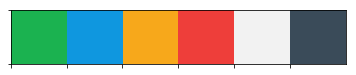

In [75]:
bellhops_pallette = ["#1BB250","#0F97DF", "#f7a81b", "#EE3E3A","#F2F2F2","#3a4b59"]
sns.set_palette(bellhops_pallette)
sns.palplot(sns.color_palette())

In [76]:
#Read csv with cleaned data into a pandas dataframe.
csv = 'move_est.csv'
df = pd.read_csv(csv, index_col = 'order_id')

#Re-transforming date columns to datetime
df['reservation_start'] = pd.to_datetime(df['reservation_start'])
df['booked_at'] = pd.to_datetime(df['booked_at'])

#### Evaluating the Scope of the Issue

In [77]:
#Percent of moves over 3hr threshold
perc_over = round(np.mean(df.over)*100)
print(perc_over,"% of all moves run over 3 hours.")

#Evaluating performance of current booking method
accuracy = sum(np.where(df.booked_over==df.over,1,0))/len(df.over)
precision = sum(np.where((df.booked_over==df.over) & (df.booked_over== 1),1,0))/sum(df.booked_over)
recall = sum(np.where((df.booked_over==df.over) & (df.booked_over== 1),1,0))/sum(df.over)
f1 = (2 * precision * recall)/(precision + recall)
pos_preds = np.mean(df.booked_over)
pos_actuals = np.mean(df.over)
false_negatives = sum(np.where((df.booked_over == 0) & (df.over==1),1,0))/len(df.over)
false_positives = sum(np.where((df.booked_over == 1) & (df.over==0),1,0))/len(df.over)

print('')
print('Performance of Current Booking Method')
print('F1: {:0.1f}'.format(round(f1*100,1)))
print('Accuracy: {:0.1f}'.format(round(accuracy*100,1))+'% of moves are booked over/under the 3 hour threshold accurately.')
print('Recall: {:0.1f}'.format(round(recall*100,1))+'% of moves that are executed over 3 hours are booked for over 3 hours.')
print('Precision: {:0.1f}'.format(round(precision*100,1))+'% of moves that are booked over 3 hours do in fact take more than 3 hours.')
print('Booked Over: {:0.1f}'.format(round(pos_preds*100,1))+'% of moves are booked over 3 hours.')
print('False Negatives: {:0.1f}'.format(round(false_negatives*100,1))+'% of moves are scheduled for less than 3 hours but run over 3 hours.')
print('False Positives: {:0.1f}'.format(round(false_positives*100,1))+'% of moves.')

34 % of all moves run over 3 hours.

Performance of Current Booking Method
F1: 57.5
Accuracy: 77.1% of moves are booked over/under the 3 hour threshold accurately.
Recall: 45.7% of moves that are executed over 3 hours are booked for over 3 hours.
Precision: 77.5% of moves that are booked over 3 hours do in fact take more than 3 hours.
Booked Over: 20.0% of moves are booked over 3 hours.
False Negatives: 18.4% of moves are scheduled for less than 3 hours but run over 3 hours.
False Positives: 4.5% of moves.


False negatives are what cause the most operational headache and customer frustration. In addition, they prevent Bellhops from feeling capable of being able to move to a more efficent schedule that would allow trucks to do 3 moves a day instead of two. Because 1 out of 5 moves unexpectedly runs over the 3 hour mark, management does not feel that the copmany can make the switch from the 2 slots a day with mostly 2 movers per order schedule to a 3 slot per day schedule with larger average crew sizes.

#### Move Length and Man Hour Distributions

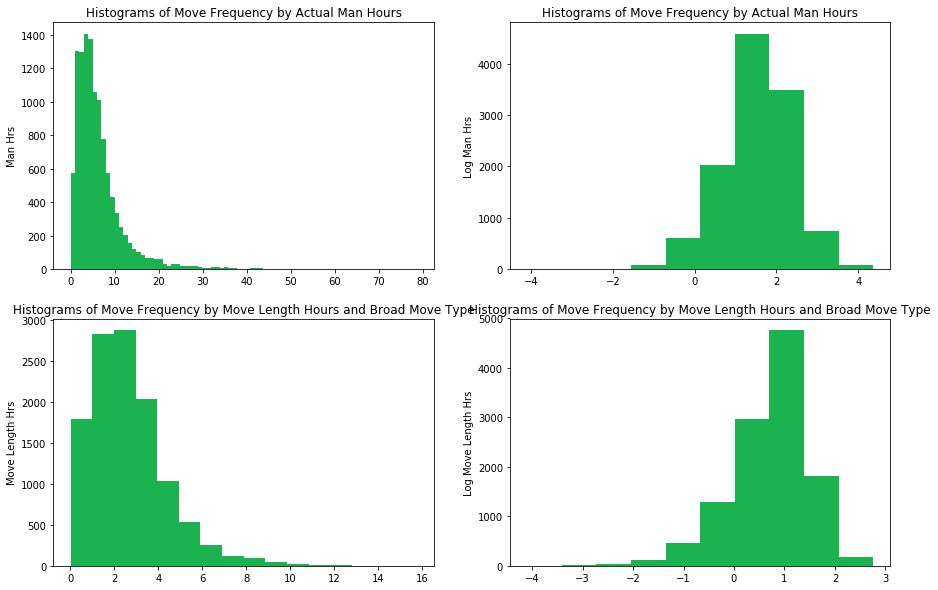

In [78]:
plt.figure(figsize=(15,10))
ax1 = plt.subplot(2,2,1)
n_bins = int(np.ceil(max(df.actual_man_hours)-min(df.actual_man_hours)))
plt.hist(df.actual_man_hours, bins = n_bins)
plt.title('Histograms of Move Frequency by Actual Man Hours')
plt.ylabel('Man Hrs')

ax2 = plt.subplot(2,2,2)
plt.hist(np.log(df.actual_man_hours))
plt.title('Histograms of Move Frequency by Actual Man Hours')
plt.ylabel('Log Man Hrs')

ax3 = plt.subplot(2,2,3)
n_bins = int(np.ceil(max(df.move_length_hours)-min(df.move_length_hours)))
plt.hist(df.move_length_hours, bins = n_bins)
plt.title('Histograms of Move Frequency by Move Length Hours and Broad Move Type')
plt.ylabel('Move Length Hrs')

ax4 = plt.subplot(2,2,4)
plt.hist(np.log(df.move_length_hours))
plt.title('Histograms of Move Frequency by Move Length Hours and Broad Move Type')
plt.ylabel('Log Move Length Hrs')

plt.show()

#### Broad Move Types
Bellhops knows that broad move types (FS vs. LO) impact move length. For starters, all FS moves are multi-location (we are moving a customer out one location and into another) while most LO move are single-location (we are moving a customer either into or out of a location.) This should be the first, most obviouse factor we should evaluate in regards to move length. 

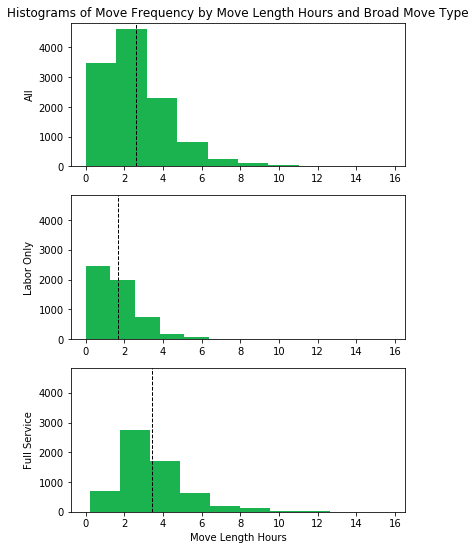

53 % of full service moves are over 3 hours long while only 12 % of labor only moves are.


In [79]:
#What do move length distributions look like by broad move type?
plt.figure(figsize=(6,9))
ax1 = plt.subplot(3,1,1)
plt.hist(df.move_length_hours)
plt.axvline(df.move_length_hours.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Histograms of Move Frequency by Move Length Hours and Broad Move Type')
plt.ylabel('All')

plt.subplot(3,1,2,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.fs==0])
plt.axvline(df.move_length_hours[df.fs==0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Labor Only')

plt.subplot(3,1,3,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.fs==1])
plt.axvline(df.move_length_hours[df.fs==1].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Full Service')
plt.xlabel('Move Length Hours')

plt.show()

#Percent of moves that run over 3hr threshold by broad move type
print(round((df['over'][df['fs']==1].mean())*100),"% of full service moves are over 3 hours long while only",round((df['over'][df['fs']==0].mean())*100),"% of labor only moves are.")

In [80]:
#In the future, we will want to label chart legends with "FS" and "LO", rather than the boolean values of 'fs.'
#Generating 'broad_move_type' column so that is easier.
df['broad_move_type'] = df['fs'].replace({0: 'LO', 1: 'FS'})

#### Number of Stops
It would make sense the the number of stops on a move would be driving the difference in move lengths between these two move types.

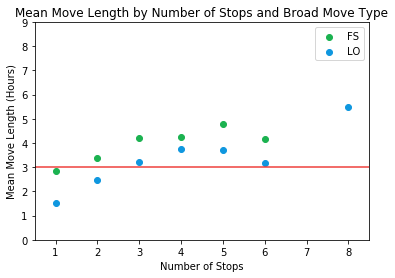

In [81]:
#Generating scatter plot of Mean Move Lengths by Number of Stops and Broad Move Type
stops = df['move_length_hours'].groupby([df['stops'],df['broad_move_type']]).mean().unstack().reset_index()
plt.scatter(stops['stops'],stops['FS'])
plt.scatter(stops['stops'],stops['LO'])
plt.title('Mean Move Length by Number of Stops and Broad Move Type')
plt.xlabel('Number of Stops')
plt.ylabel('Mean Move Length (Hours)')
plt.xlim(.5,8.5)
plt.ylim(0,max(max(stops['LO']),max(stops['FS'])))
plt.xticks(np.arange(1, 9, step=1))
plt.axhline(y=3, xmin=0, xmax=1, hold=None, color="#EE3E3A")
plt.legend()
plt.show()

It appears that mean move length is largely driven by number of stops, but for a given number of stops, the mean lengths of FS moves still tend to be longer than LO moves'. 

#### Move Types
In addition to "broad move types," Bellhops has a more granualar category of moves simply called "move types." There are 5 we included in this analysis:
* gopher - This is the move type that represents FS moves, multi-location moves where Bellhops provides a truck. All other move types represent LO moves.
* atob - These are multilocation moves where Bellhops does not provide a truck. The customers rent and driver trucks themselves.
* loading - Bellhops moves a customer out of a location (by loading a truck/pod/etc.)
* unloading - Bellhops moves a customer into a new location (by unloading a truck/pod/etc.)
* inhouselabor - Bellhops is not necessarily moving a customer from one location to the next, but rather moving items within a home. 

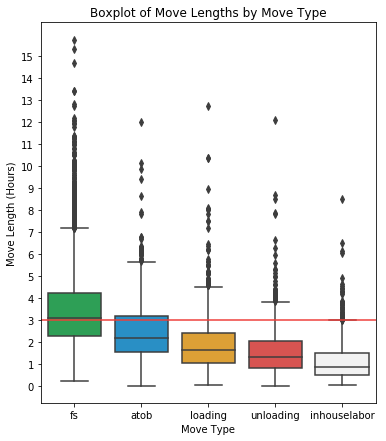

In [82]:
#Generating a boxplot of move lengths by move type.
plt.figure(figsize=(6,7))
ax = sns.boxplot(x="move_type", y="move_length_hours", order=["fs", "atob","loading","unloading","inhouselabor"], data=df)
ax.set_title('Boxplot of Move Lengths by Move Type')
ax.set_ylabel('Move Length (Hours)')
ax.set_xlabel('Move Type')
plt.yticks(np.arange(0, max(df.move_length_hours), step=1))
plt.axhline(y=3, xmin=0, xmax=1, hold=None, color="#EE3E3A")
plt.show()

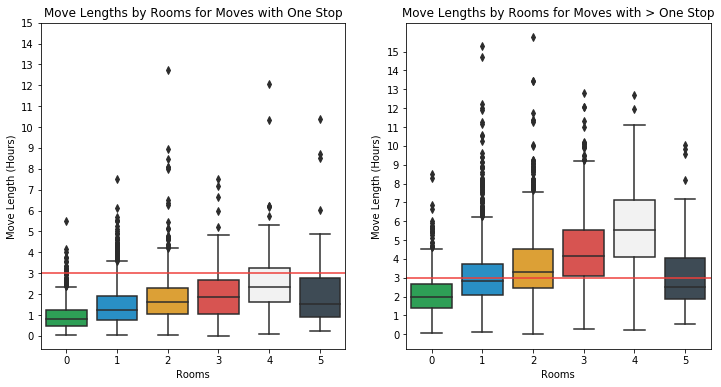

In [83]:
#Generating boxplots of move lengths by number of rooms and stops.
plt.figure(figsize=(12,6))
ax1 = plt.subplot(1,2,1)
ax = sns.boxplot(x="rooms", y="move_length_hours", data=df[df.stops==1])
ax.set_title('Move Lengths by Rooms for Moves with One Stop')
ax.set_ylabel('Move Length (Hours)')
ax.set_xlabel('Rooms')
plt.yticks(np.arange(0, max(df.move_length_hours), step=1))
plt.axhline(y=3, xmin=0, xmax=1, hold=None, color="#EE3E3A")

ax1 = plt.subplot(1,2,2)
ax = sns.boxplot(x="rooms", y="move_length_hours", data=df[df.stops>1])
ax.set_title('Move Lengths by Rooms for Moves with > One Stop')
ax.set_ylabel('Move Length (Hours)')
ax.set_xlabel('Rooms')
plt.yticks(np.arange(0, max(df.move_length_hours), step=1))
plt.axhline(y=3, xmin=0, xmax=1, hold=None, color="#EE3E3A")

plt.show()

There do seem to be large differences in move lengths between variouse move types. Part of this is explained by the number of stops. (FS/'gopher' and 'atob' have at least two stops, the rest usualy only have one stop.) FS/gopher is the largest offender for running over 3 hours. A to b is the only other move type with the 3 hour mark within it's inner-quartile range. In house labor is the shortest move type, with more than 75% of it's moves below the 3 hours mark.

#### Markets


It's no surprise that markets have different mean move lengths as well as different mean move lengths for each broad move type. However, a relationship between mean move length for fs and lo moves would suggest that there is something systematic about a particular market makes moves longer or shorter. 

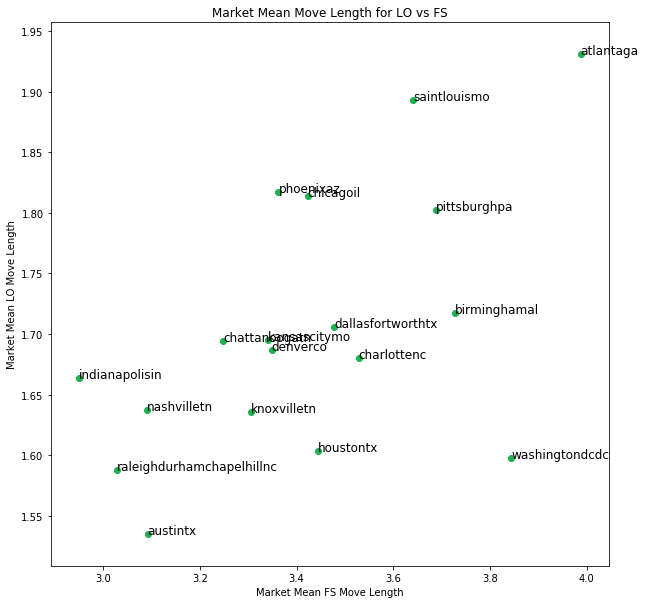

In [84]:
# Bellhops has a hunch that there are persistent move length differences among markets. Here are mean move lengths by market and move type.
ml = pd.crosstab(df.market, df.fs, values=df.move_length_hours, aggfunc=np.mean)

ml = ml.sort_values(1,ascending=False)

# Removing any obviouse an outliers.
mla = ml[ml[0] < 4]

# Reseting the index for easier plotting
mla.reset_index(inplace=True)

# Scatter plot
plt.figure(figsize=(10,10))
plt.scatter(mla[1],mla[0])
plt.title('Market Mean Move Length for LO vs FS')
plt.xlabel('Market Mean FS Move Length')
plt.ylabel('Market Mean LO Move Length')

for i, market in enumerate(mla.market):
    plt.annotate(mla.market[i], (mla[1][i],mla[0][i]), fontsize=12, rotation = 0)
plt.show()

It does seem like mean move length for FS and LO for a market are positively correlated. There could be many stories that support this hypothesis. Maybe customers tend to have more belongings in some markets, maybe in some markets Bellhops' movers tend to work more efficiently, maybe in some markets there are demographic or geographic difference that make moves take longer. We will attempt to uncover the latter by looking at the relationship bettwen population density and move length below.

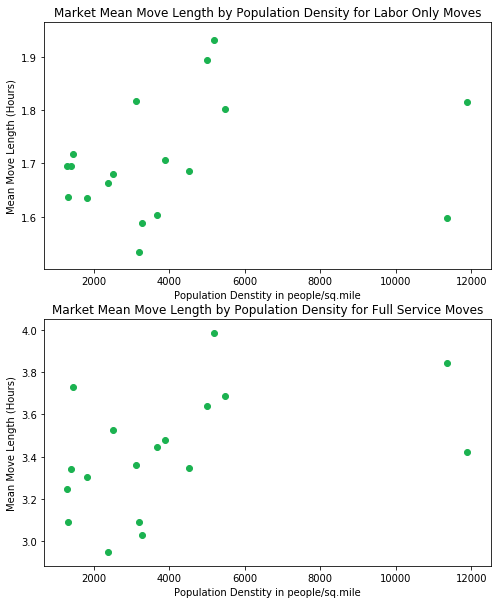

In [85]:
#Are these market specific differences driven by population density?
pop = pd.DataFrame(df['pop_density'].groupby(df['market']).mean())
ml_pop = ml.join(pop)

plt.figure(figsize=(8,10))
ax1 = plt.subplot(2,1,1)
plt.scatter(ml_pop.pop_density,[ml_pop[0]])
plt.title('Market Mean Move Length by Population Density for Labor Only Moves')
plt.xlabel('Population Denstity in people/sq.mile')
plt.ylabel('Mean Move Length (Hours)')

plt.subplot(2,1,2,sharex=ax1)
plt.scatter(ml_pop.pop_density,[ml_pop[1]])
plt.title('Market Mean Move Length by Population Density for Full Service Moves')
plt.xlabel('Population Denstity in people/sq.mile')
plt.ylabel('Mean Move Length (Hours)')
plt.show()


There is a small sample size, less than 20 markets, but both population density seems to be positively correlated move length for both FS and LO moves.

#### Drive Time Between Waypoints
Intuitively, you would think that every additional minute spent driving between waypoints would increase move length by roughly a minute.

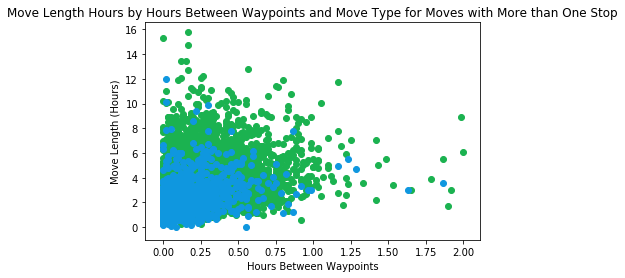

In [86]:
#Generating scatter plot for Move Length and Hours Between Waypoints
plt.scatter(df['hours_between_waypoints'][(df['fs']==1) & (df['stops']>1)],df['move_length_hours'][(df['fs']==1) & (df['stops']>1)])
plt.scatter(df['hours_between_waypoints'][(df['fs']==0) & (df['stops']>1)],df['move_length_hours'][(df['fs']==0) & (df['stops']>1)])
plt.title('Move Length Hours by Hours Between Waypoints and Move Type for Moves with More than One Stop')
plt.ylabel('Move Length (Hours)')
plt.xlabel('Hours Between Waypoints')
plt.show()

While it does look like there is a positive correlation, the relationship isn't extremely clear here. Noise caused by other factor swamps the impact visually.

#### Flights of Stairs
It would make sense to think that all else constant, an additional flight of stairs on a move would increase move length.

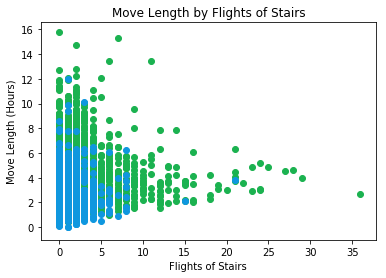

In [87]:
#Scatter plot for flights of stairs
plt.scatter(df['flights_of_stairs'][(df['fs']==1) & (df['stops']>1)],df['move_length_hours'][(df['fs']==1) & (df['stops']>1)])
plt.scatter(df['flights_of_stairs'][(df['fs']==0) & (df['stops']>1)],df['move_length_hours'][(df['fs']==0) & (df['stops']>1)])
plt.title('Move Length by Flights of Stairs')
plt.xlabel('Flights of Stairs')
plt.ylabel('Move Length (Hours)')
plt.show()

Similarly to the Drive Time Between Waypoints Scatter, move length does seem to be positively correlated with flights of stairs.

#### Mover Quality
It would make sense to think that all else constant, having movers that were often late or received poor customer ratings on preivous moves would results in longer moves.

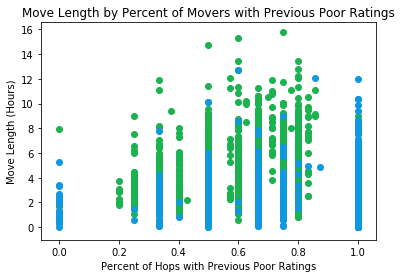

In [88]:
#Scatter plot for Percent of Hops with Previous Poor Ratings
plt.scatter(df['avg_bad_star_hops'][(df['fs']==1)],df['move_length_hours'][(df['fs']==1)])
plt.scatter(df['avg_bad_star_hops'][(df['fs']==0)],df['move_length_hours'][(df['fs']==0)])
plt.title('Move Length by Percent of Movers with Previous Poor Ratings')
plt.xlabel('Percent of Hops with Previous Poor Ratings')
plt.ylabel('Move Length (Hours)')
plt.show()

It does look like there is a positive relationship between previous poor ratings and move length. What about for lateness as well?

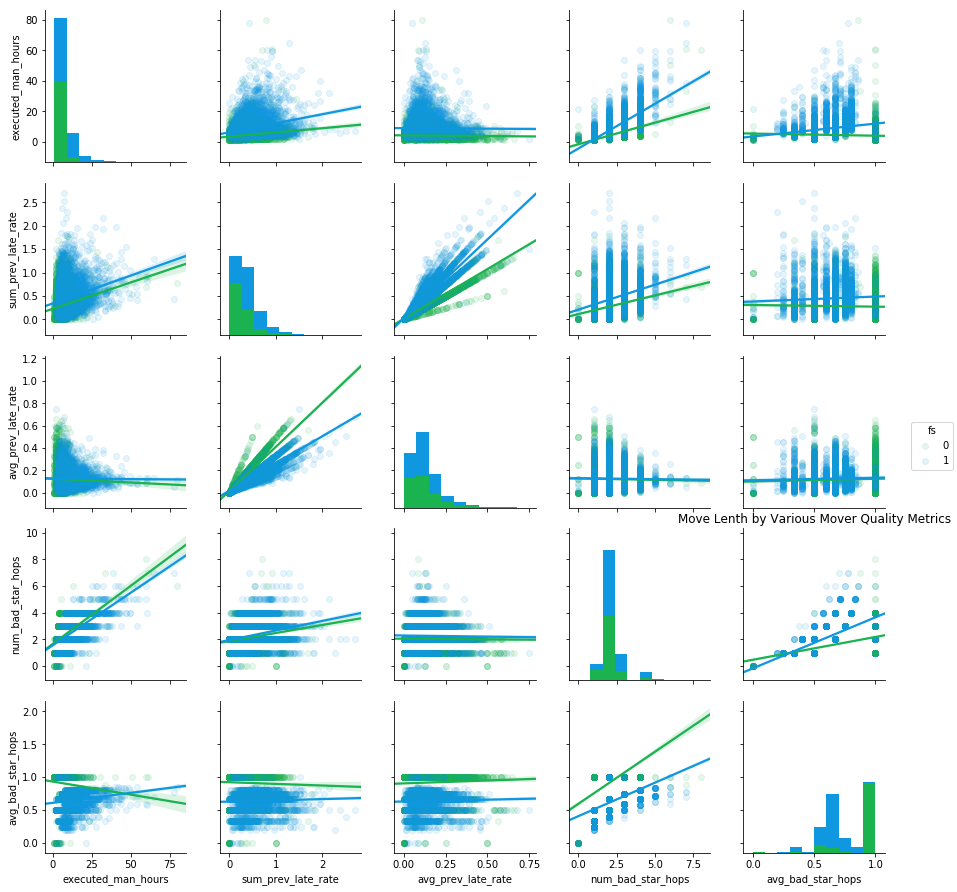

In [89]:
#Pair plots with executed man hour and mover quality metrics
pair_vars = ['executed_man_hours','sum_prev_late_rate','avg_prev_late_rate','num_bad_star_hops','avg_bad_star_hops']
sns.pairplot(df, vars= pair_vars, hue='fs',kind="reg", plot_kws={'scatter_kws': {'alpha': 0.1}})
plt.title('Move Lenth by Various Mover Quality Metrics')
plt.show()

### Additional Feature Engineering

In [90]:
#Adding columns that are iterations off of existing columns
df['log_man_hours'] = np.log(df['executed_man_hours'])
df['second_stop'] = np.where(df['stops'] >=2,1,0)
df['extra_stop'] = np.where(((df['fs']==1)|(df['move_type']=='atob')), df.stops-2, df.stops-1)
df['extra_hop'] = np.where(df['order_total_spots'] >2,df['order_total_spots'] - 2,0)
df['web_extra_hop'] = np.where((df['order_total_spots'] >2) & (df['phone'] == 1),df['order_total_spots'] - 2,0)
df['extra_rooms'] = np.where(df['rooms'] > 1,df['rooms']-1,0)
df['coupon'] = np.where(df['coupon_amount'] > 0,1,0)

In [91]:
#Adding interaction columns
df['fs_dense'] = df['fs']*df['dense']
df['fs_rooms'] = df['fs']*df['rooms']
df['fs_stops'] = df['fs']*df['stops']
df['dense_apt'] = np.where((df['property_type_name']=='Apartment/Condo') & (df['dense']==1),1,0)

df['second_stop_extra_rooms'] = df['second_stop']*df['extra_rooms']
df['second_stop_dense'] = df['second_stop']*df['dense']
df['second_stop_extra_rooms_dense'] = df['second_stop']*df['extra_rooms']*df['dense']

df['house_rooms'] = df['house']*df['rooms']
df['rooms_stairs'] = df['rooms']*df['flights_of_stairs']
df['rooms_stops'] = df.rooms*df.stops
df['rooms_stops_square'] = df.rooms_stops * df.rooms_stops
df['rooms_stairs_stops'] = df['rooms']*df['flights_of_stairs']* df['stops']
df['rooms_squared'] = df['rooms']*df['rooms']
df['rooms_spots'] = df['rooms']*df['order_total_spots']

In [92]:
#Creating columns for average move length by move type and market
mkt_lo_avg = ml[ml.columns[0]].to_frame()
mkt_lo_avg = mkt_lo_avg.rename(index=str, columns={0: "lo_mkt_avg"})
mkt_lo_avg = mkt_lo_avg.reset_index()
df = pd.merge(df, mkt_lo_avg, left_on='market', right_on='market')

mtm = pd.crosstab(df.market, df.move_type, values=df.move_length_hours, aggfunc=np.mean)
mtm = mtm.reset_index()
mtm.columns = [str(col) + '_mkt_avg' for col in mtm.columns]
df = pd.merge(df, mtm, left_on='market', right_on='market_mkt_avg')
df = df.drop('market_mkt_avg', axis = 1)


df['avg_bmt_mkt'] = np.where(df.fs==1,df['fs_mkt_avg'],df.lo_mkt_avg)

df['avg_mt_mkt'] = np.where(df.move_type=='fs', df['fs_mkt_avg'], np.where(df.move_type=='inhouselabor',df.inhouselabor_mkt_avg,np.where(df.move_type=='loading',df.loading_mkt_avg,np.where(df.move_type=='atob', df.atob_mkt_avg, df.unloading_mkt_avg))))

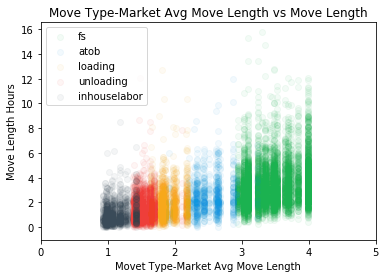

In [93]:
#Scatter plot of Movet Type-Market Avg Move Length by Move Type
plt.title('Move Type-Market Avg Move Length vs Move Length')
plt.xlabel('Movet Type-Market Avg Move Length')
plt.ylabel('Move Length Hours')
plt.scatter(df[df.move_type=='fs'].avg_mt_mkt, df[df.move_type=='fs'].move_length_hours, label="fs", alpha = .05)
plt.scatter(df[df.move_type=='atob'].avg_mt_mkt, df[df.move_type=='atob'].move_length_hours, label="atob", alpha = .05)
plt.scatter(df[df.move_type=='loading'].avg_mt_mkt, df[df.move_type=='loading'].move_length_hours, label="loading", alpha = .05)
plt.scatter(df[df.move_type=='unloading'].avg_mt_mkt, df[df.move_type=='unloading'].move_length_hours, label="unloading", alpha = .05)
plt.scatter(df[df.move_type=='inhouselabor'].avg_mt_mkt, df[df.move_type=='inhouselabor'].move_length_hours, label="inhouselabor",color = "#3a4b59", alpha = .05)
plt.legend(loc='upper left')
plt.xlim([0,5])
plt.show()

In [94]:
# Make an empty list
mkt_mt_avg_hours = []

# For each row in the df
for index, row in df.iterrows():
    # Get the market, move_type, booked_at, and reservation_start
    market = row.market
    move_type = row.move_type
    booked_at = row.booked_at
    reservation_start = row.reservation_start
    # Filter dataframe such that market = market value and move type = move type value
    # and all remaining moves started between 24 hours and 2 months before the move in question was booked
    df_i = df[(df.market == market) & (df.move_type== move_type) & ((pd.to_datetime(booked_at) - df.reservation_start).astype('timedelta64[h]')/(24) >= 1) & ((pd.to_datetime(booked_at) - df.reservation_start).astype('timedelta64[h]')/(24*30.43)<=2)]
    # Get the mean of the move length hours of the filtered dataframe
    avg = np.mean(df_i.move_length_hours)
    # Append the avg to avg_move_length
    mkt_mt_avg_hours.append(avg)


In [95]:
# Add a new column, mkt_mt_avg_hours, to df
df['avg_hrs_mkt_mt'] = mkt_mt_avg_hours

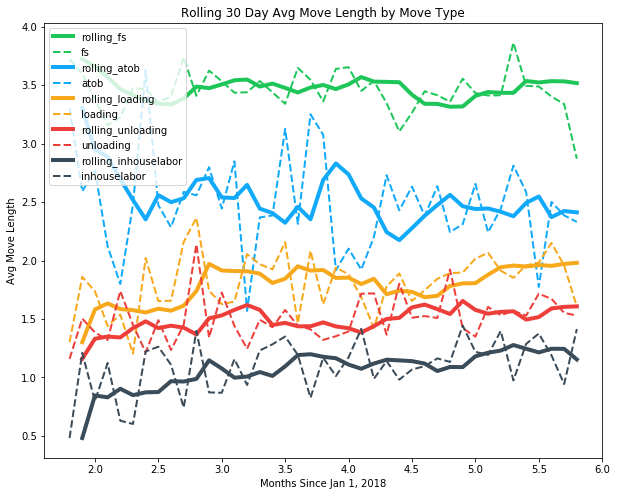

In [96]:
df['roll_bucket'] = np.floor(df.nb_months*10)/10

mon = pd.crosstab(df.roll_bucket, df.move_type, values=df.move_length_hours, aggfunc=np.mean)
mon = mon.reset_index()
mon['rolling_fs'] = mon.fs.shift(1).rolling(window=5, min_periods = 1).mean()
mon['rolling_atob'] = mon.atob.shift(1).rolling(window=5, min_periods = 1).mean()
mon['rolling_unloading'] = mon.unloading.shift(1).rolling(window=5, min_periods = 1).mean()
mon['rolling_loading'] = mon.loading.shift(1).rolling(window=5, min_periods = 1).mean()
mon['rolling_inhouselabor'] = mon.inhouselabor.shift(1).rolling(window=5, min_periods = 1).mean()


# multiple line plot
plt.figure(figsize=(10,8))
plt.plot( 'roll_bucket', 'rolling_fs', data=mon, marker='', markersize=12, color="#1EC659", linewidth=4)
plt.plot( 'roll_bucket', 'fs', data=mon, marker='', color="#1EC659", linewidth=2, linestyle='dashed')
plt.plot( 'roll_bucket', 'rolling_atob', data=mon, marker='', color="#11A9F9", linewidth=4)
plt.plot( 'roll_bucket', 'atob', data=mon, marker='', color="#11A9F9", linewidth=2, linestyle='dashed')
plt.plot( 'roll_bucket', 'rolling_loading', data=mon, marker='', color="#f7a81b", linewidth=4)
plt.plot( 'roll_bucket', 'loading', data=mon, marker='', color="#f7a81b", linewidth=2, linestyle='dashed')
plt.plot( 'roll_bucket', 'rolling_unloading', data=mon, marker='', color="#EE3E3A", linewidth=4)
plt.plot( 'roll_bucket', 'unloading', data=mon, marker='', color="#EE3E3A", linewidth=2, linestyle='dashed')
plt.plot( 'roll_bucket', 'rolling_inhouselabor', data=mon, marker='', color="#3a4b59", linewidth=4)
plt.plot( 'roll_bucket', 'inhouselabor', data=mon, marker='', color="#3a4b59", linewidth=2, linestyle='dashed')
plt.title('Rolling 30 Day Avg Move Length by Move Type')
plt.ylabel('Avg Move Length')
plt.xlabel('Months Since Jan 1, 2018')
plt.legend(loc='upper left')
plt.show()


#Adding columns for rolling averages to df
mon = mon.drop(['atob','fs','inhouselabor','loading','unloading'],axis = 1)

df = pd.merge(df, mon, left_on='roll_bucket', right_on='roll_bucket')

df['rolling_mt'] = np.where(df.move_type=='fs', df['rolling_fs'], np.where(df.move_type=='inhouselabor',df.rolling_inhouselabor,np.where(df.move_type=='loading',df.rolling_loading,np.where(df.move_type=='atob', df.rolling_atob, df.rolling_unloading))))

df = df.drop(['roll_bucket','rolling_fs','rolling_atob','rolling_unloading','rolling_loading','rolling_inhouselabor'],axis = 1)


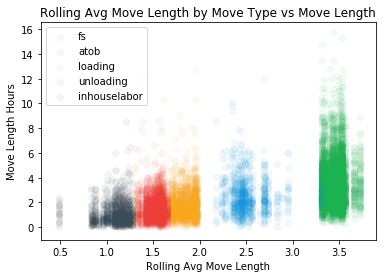

In [98]:
#Scatter plot of Rolling Avg Move Length by Move Type 
plt.title('Rolling Avg Move Length by Move Type vs Move Length')
plt.xlabel('Rolling Avg Move Length')
plt.ylabel('Move Length Hours')
plt.scatter(df[df.move_type=='fs'].rolling_mt, df[df.move_type=='fs'].move_length_hours, label="fs", alpha = .05)
plt.scatter(df[df.move_type=='atob'].rolling_mt, df[df.move_type=='atob'].move_length_hours, label="atob", alpha = .05)
plt.scatter(df[df.move_type=='loading'].rolling_mt, df[df.move_type=='loading'].move_length_hours, label="loading", alpha = .05)
plt.scatter(df[df.move_type=='unloading'].rolling_mt, df[df.move_type=='unloading'].move_length_hours, label="unloading", alpha = .05)
plt.scatter(df[df.move_type=='inhouselabor'].rolling_mt, df[df.move_type=='inhouselabor'].move_length_hours, label="inhouselabor",color = "#3a4b59", alpha = .05)
plt.legend(loc='upper left')
plt.show()

There is clearly a positive relationship between Move Length and Rolling Avg Move Length. However, the real question is if there is a positive correlation with move types.

In [99]:
#Removing rows from df that from markets that don't have rolling averages
print("Remaining Rows:",len(df.over))
df = df.dropna()
print("Remaining Rows After Dropping Rows with NAs:",len(df.over))

Remaining Rows: 11640
Remaining Rows After Dropping Rows with NAs: 10862


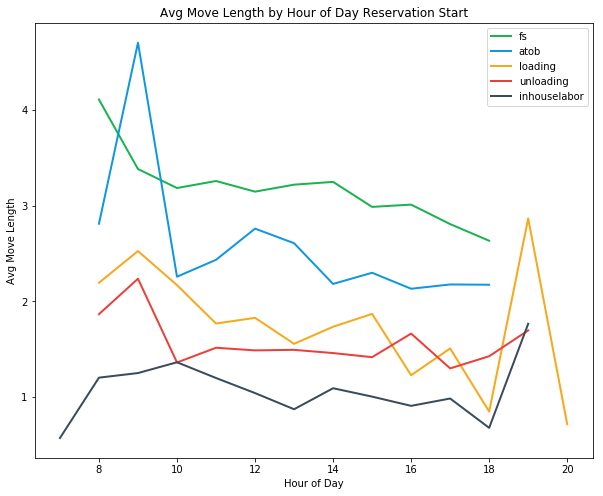

In [100]:
hod = pd.crosstab(df.hour_of_day, df.move_type, values=df.move_length_hours, aggfunc=np.mean)
hod = hod.reset_index()

# multiple line plot
plt.figure(figsize=(10,8))

plt.plot( 'hour_of_day', 'fs', data=hod, marker='', linewidth=2)
plt.plot( 'hour_of_day', 'atob', data=hod, marker='', linewidth=2)
plt.plot( 'hour_of_day', 'loading', data=hod, marker='', linewidth=2)
plt.plot( 'hour_of_day', 'unloading', data=hod, marker='', linewidth=2)
plt.plot( 'hour_of_day', 'inhouselabor', data=hod, marker='', linewidth=2,color = "#3a4b59")
plt.title('Avg Move Length by Hour of Day Reservation Start')
plt.ylabel('Avg Move Length')
plt.xlabel('Hour of Day')
plt.legend(loc='upper right')
plt.show()

hod.columns = ['hod_' + str(col) for col in hod.columns]

df = pd.merge(df, hod, left_on='hour_of_day', right_on='hod_hour_of_day')

df['hod_mt_avg'] = np.where(df.move_type=='fs', df['hod_fs'], np.where(df.move_type=='inhouselabor',df.hod_inhouselabor,np.where(df.move_type=='loading',df.hod_loading,np.where(df.move_type=='atob', df.hod_atob, df.hod_unloading))))
df = df.drop(['hod_hour_of_day','hod_fs','hod_atob','hod_loading','hod_unloading','hod_inhouselabor'],axis=1)

#There seems to be a particularly strong correlation between move length and hour of day for move types with multiple stops
df['hod_stops'] = df.hour_of_day*df.stops

It definitely looks like there is a negative relationship here across move types. Further more, it looks like there are different slopes per move type. We may want to take that into account with feature engineering.

In [101]:
#Removing rows from df that from markets that don't have rolling averages
print("Remaining Rows:",len(df.over))
df = df.dropna()
print("Remaining Rows After Dropping Rows with NAs:",len(df.over))

Remaining Rows: 10862
Remaining Rows After Dropping Rows with NAs: 10862


# Machine Learning


In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
from sklearn.preprocessing import StandardScaler

In [103]:
#Making a df for prediction (dfp) that only includes 
#a) columns that are numeric 
#b) columns that contain information Bellhops has before the move starts and before speific movers are assigned
#c) columns that aren't redundant
df_p = df.drop(['booked_over','booked_man_hours','market', 'move_type','move_length_hours',
               'executed_man_hours','property_size_name','property_type_name','reservation_start', 'booked_at','minutes_between_waypoints',
               'miles_between_waypoints','max_late_clock_in_hours','sum_late_clock_in_hours','actual_man_hours','correct_booked_man_hours', 'log_man_hours','broad_move_type',
                'num_bad_star_hops','avg_prev_late_rate', 'sum_prev_late_rate','avg_bad_star_hops','num_effort_hops','lo_mkt_avg', 'atob_mkt_avg',
               'fs_mkt_avg', 'inhouselabor_mkt_avg', 'loading_mkt_avg',
               'unloading_mkt_avg', 'avg_bmt_mkt', 'rolling_mt', 'avg_mt_mkt'
              ], axis=1)

#List remaining columns
pprint(df_p.columns.values)

array(['order_total_spots', 'fs', 'house', 'residence', 'rooms',
       'coupon_amount', 'grpn', 'dense', 'flights_of_stairs', 'stops',
       'elevators', 'additional_instructions', 'phone', 'city_pop',
       'pop_density', 'hours_between_waypoints', 'over', 'hour_of_day',
       'morning', 'day_of_week', 'weekend', 'lead_days', 'nb_months',
       'nb_days', 'mkt_atlantaga', 'mkt_austintx', 'mkt_birminghamal',
       'mkt_charlottenc', 'mkt_chattanoogatn', 'mkt_chicagoil',
       'mkt_dallasfortworthtx', 'mkt_denverco', 'mkt_houstontx',
       'mkt_indianapolisin', 'mkt_kansascitymo', 'mkt_knoxvilletn',
       'mkt_nashvilletn', 'mkt_phoenixaz', 'mkt_pittsburghpa',
       'mkt_raleighdurhamchapelhillnc', 'mkt_saintlouismo',
       'mkt_sanantoniotx', 'mkt_washingtondcdc', 'mt_atob', 'mt_fs',
       'mt_inhouselabor', 'mt_loading', 'mt_unloading', 'second_stop',
       'extra_stop', 'extra_hop', 'web_extra_hop', 'extra_rooms',
       'coupon', 'fs_dense', 'fs_rooms', 'fs_stops', 'den

In [104]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = sum(np.where(predictions==y_test,1,0))/len(y_test)
    precision = sum(np.where((predictions==y_test) & (predictions== 1),1,0))/sum(predictions)
    recall = sum(np.where((predictions==y_test) & (predictions== 1),1,0))/sum(y_test)
    f1 = (2 * precision * recall)/(precision + recall)
    pos_preds = np.mean(predictions)
    pos_actuals = np.mean(y_test)
    false_negatives = sum(np.where((predictions == 0) & (y_test == 1),1,0))/len(y_test)
    false_positives = sum(np.where((predictions == 1) & (y_test == 0),1,0))/len(y_test)
    
    print('')
    print('Model Performance')
    print('F1: {:0.1f}'.format(round(f1*100,1)))
    print('Accuracy: {:0.1f}'.format(round(accuracy*100,1)),'%')
    print('Recall: {:0.1f}'.format(round(recall*100,1)),'%')
    print('Precision: {:0.1f}'.format(round(precision*100,1)),'%')
    print('Positive Predictions: {:0.1f}'.format(round(pos_preds*100,1)),'%')
    print('Positive Actuals: {:0.1f}'.format(round(pos_actuals*100,1)),'%')
    print('False Negatives: {:0.1f}'.format(round(false_negatives*100,1)),'%') 
    print('False Positives: {:0.1f}'.format(round(false_positives*100,1)),'%') 

## Logistic Regression

In [136]:
#Drop columns that should not be included in logistic regression, like default values for dummy variables
df_lr = df_p.drop(['mkt_chattanoogatn','mt_inhouselabor'], axis = 1)


In [137]:
#'Over' is the binary column that indicates whether or not the move went over the 3 hour mark
training_target_lr = df_lr.over
training_features_lr = df_lr.drop('over',axis = 1)

In [138]:
# Split the data into a training and test set.
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(training_features_lr, training_target_lr,
                                                  test_size = .1,
                                                  random_state = 42)

In [139]:
#Checking to make sure run over rate is roughly equivalent for test set and total sample
print('Total Sample:',round(np.mean(df_lr.over)*100),'%')
print('Test Set:',round(np.mean(y_test_lr)*100),'%')

Total Sample: 33.0 %
Test Set: 36.0 %


In [140]:
#Need to identify dummy columns so we can normalize non-dummy columns
market_dummies  = [col for col in df if col.startswith('mkt')]

move_type_dummies = [col for col in df if col.startswith('mt')]

dummies =  market_dummies + move_type_dummies + ['fs','over','house','residence','grpn','grpn200','additional_instructions','phone','morning','weekend','second_stop','extra_stop','extra_hop','web_extra_hop','coupon','fs_dense','dense_apt','fs_long_dow','dense'] 

not_dummies = [col for col in df_lr.columns if col not in dummies]

#Find mean and standard deviation of all non-dummy columns
means = np.mean(X_train_lr.loc[:,not_dummies], axis=0)
stds = np.std(X_train_lr.loc[:,not_dummies], axis=0)

#Normalize non-dummy columns and make smaller dfs with normalized non-dummy features
normalized_train = (X_train_lr.loc[:,not_dummies] - means)/stds
normalized_test = (X_test_lr.loc[:,not_dummies] - means)/stds

#Drop non-normalized non-dummy columns
X_train_lr = X_train_lr.drop(not_dummies, axis=1)
X_test_lr = X_test_lr.drop(not_dummies, axis=1)

#Add normalized columns
X_train_lr[not_dummies] = normalized_train
X_test_lr[not_dummies] = normalized_test

#Check that new means equal 0
print("Min Mean:",np.round(np.min(np.mean(X_train_lr[not_dummies], axis=0))),"Max Mean:",np.round(np.max(np.mean(X_train_lr[not_dummies], axis=0))))

# Check that new stds equal 1
print("Min Std:",np.min(round(np.std(X_train_lr[not_dummies], axis=0))),"Max Std:",np.max(round(np.std(X_train_lr[not_dummies], axis=0))))


Min Mean: -0.0 Max Mean: 0.0
Min Std: 1.0 Max Std: 1.0


In [141]:
X_train_lr.columns.values

array(['fs', 'house', 'residence', 'grpn', 'dense',
       'additional_instructions', 'phone', 'morning', 'weekend',
       'mkt_atlantaga', 'mkt_austintx', 'mkt_birminghamal',
       'mkt_charlottenc', 'mkt_chicagoil', 'mkt_dallasfortworthtx',
       'mkt_denverco', 'mkt_houstontx', 'mkt_indianapolisin',
       'mkt_kansascitymo', 'mkt_knoxvilletn', 'mkt_nashvilletn',
       'mkt_phoenixaz', 'mkt_pittsburghpa',
       'mkt_raleighdurhamchapelhillnc', 'mkt_saintlouismo',
       'mkt_sanantoniotx', 'mkt_washingtondcdc', 'mt_atob', 'mt_fs',
       'mt_loading', 'mt_unloading', 'second_stop', 'extra_stop',
       'extra_hop', 'web_extra_hop', 'coupon', 'fs_dense', 'dense_apt',
       'order_total_spots', 'rooms', 'coupon_amount', 'flights_of_stairs',
       'stops', 'elevators', 'city_pop', 'pop_density',
       'hours_between_waypoints', 'hour_of_day', 'day_of_week',
       'lead_days', 'nb_months', 'nb_days', 'extra_rooms', 'fs_rooms',
       'fs_stops', 'second_stop_extra_rooms', 'seco

#### Logistic Regression Model #1: Incorporating All Features

In [142]:
#Using GridSearchCV to perform cross validation and grid search to find the best model over the training set
#Note: For C, smaller values mean stronger regularization. L1 is Lasso and L2 is ridge regression.
lr = LogisticRegression(class_weight = 'balanced')
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000], "penalty":['l1']}
fitmodel = GridSearchCV(lr, param_grid=parameters, cv=5, scoring='accuracy', return_train_score=True)
fitmodel.fit(X_train_lr, y_train_lr)

#Helpful potential outputs are: fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_
print('Evaluating Grid Search Model')
print(fitmodel.best_params_, fitmodel.best_score_)
best_grid = fitmodel.best_estimator_
evaluate(best_grid,X_test_lr, y_test_lr)

Evaluating Grid Search Model
{'C': 1, 'penalty': 'l1'} 0.7546803069053708

Model Performance
F1: 69.9
Accuracy: 75.7 %
Recall: 79.1 %
Precision: 62.7 %
Positive Predictions: 45.1 %
Positive Actuals: 35.7 %
False Negatives: 7.5 %
False Positives: 16.8 %


In [143]:
#Static Version of Best LR1 (all features included) Model  
lr1 = LogisticRegression(class_weight = 'balanced', C=1, penalty = 'l1')
lr1.fit(X_train_lr, y_train_lr)
print('Evaluating Grid Search Model')
best_grid = lr1
evaluate(best_grid,X_test_lr, y_test_lr)

Evaluating Grid Search Model

Model Performance
F1: 69.9
Accuracy: 75.7 %
Recall: 79.1 %
Precision: 62.7 %
Positive Predictions: 45.1 %
Positive Actuals: 35.7 %
False Negatives: 7.5 %
False Positives: 16.8 %


This is actually pretty similar to current booking results, which has an accuracy of 77%. However, what is promising about these results is that it almost flips the proportions of false negatives and false positives. Current booking methods have a false negative rate of 18% and a false positive rate of 5%. False negatives, where we underestimate the move length, is what causes logictical issues and particularly poor customer experiences. Holding accuracy constant but shifting away from false negatives toward more positives could actually improve the customer experience, iron out some logistical challenges, and allow the business to introduce a schedule that allows a truck to book three moves a day.

We'll see if we can optimize this further bellow by reducing the number of features that are included.

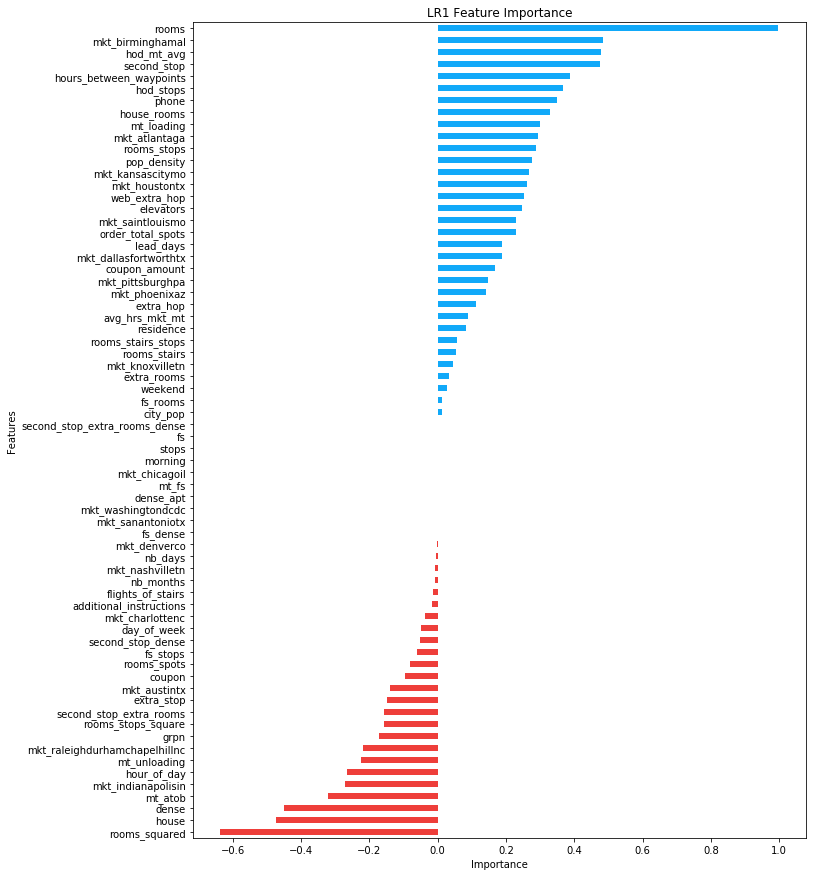

In [144]:
# Plotting Coefficients/Feature Importance
coeff = list(best_grid.coef_[0])

labels = list(X_train_lr.columns)

features = pd.DataFrame()

features['Features'] = labels

features['importance'] = coeff

features.sort_values(by=['importance'], ascending=True, inplace=True)

features['positive'] = features['importance'] > 0

features.set_index('Features', inplace=True)

ax = features.importance.plot(kind='barh', figsize=(11, 15),color = features.positive.map({True: "#11A9F9", False: "#EE3E3A"}))

plt.xlabel('Importance')
plt.title('LR1 Feature Importance')

# create a list to collect the plt.patches data
#totals = []

# find the values and append to list
#for i in ax.patches:
    #totals.append(i.get_width())

# set individual bar lables using above list
#total = sum(totals)

# set individual bar lables using above list
#for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    #ax.text(i.get_width(), i.get_y(), str(round((i.get_width()/total)*100, 2)), fontsize=12, color='black')
    
plt.show()

In [145]:
features

,importance,positive
Features,,
rooms_squared,-0.636009,False
house,-0.472984,False
dense,-0.448835,False
mt_atob,-0.320663,False
mkt_indianapolisin,-0.271047,False
hour_of_day,-0.265277,False
mt_unloading,-0.224211,False
mkt_raleighdurhamchapelhillnc,-0.217472,False
grpn,-0.171500,False


The first logistic regression model above actually incorporated too many features, as we can see above, the l1 regularization took car of some of that, but keeping the most important features in mind from above, let's build a more selective model. The first step would be to avoid including features that are too highly correlated (unless we are interested in an interactive relationship.)

In [146]:
#Finding pairs of festures that are highly correlated, so we can avoid including pairs inadvertently in later models
cor = X_train_lr.corr()
cor.loc[:,:] =  np.tril(cor, k=-1)
cor = cor.stack()
cor = cor[cor > 0.80].reset_index()
cor = cor.sort_values(by='level_0',axis=0, ascending=True)
cor.columns = ['feature_0','feature_1','correlation']
cor

,feature_0,feature_1,correlation
29,avg_hrs_mkt_mt,fs_stops,0.845155
28,avg_hrs_mkt_mt,second_stop,0.880063
27,avg_hrs_mkt_mt,mt_fs,0.881218
26,avg_hrs_mkt_mt,fs,0.881218
7,day_of_week,weekend,0.867767
3,dense_apt,dense,0.818458
9,extra_rooms,rooms,0.947840
10,fs_stops,fs,0.960233
11,fs_stops,mt_fs,0.960233
12,fs_stops,second_stop,0.828205


In [237]:
# Try logistic regression with the single variable with the most predictive power
cols_1 = ['avg_hrs_mkt_mt']

X_train_lr1 = X_train_lr[cols_1]

X_test_lr1 = X_test_lr[cols_1]

y_train_lr1 = y_train_lr

y_test_lr1 = y_test_lr

# Using GridSearchCV to perform cross validation and grid search to find the best model over the training set
lr = LogisticRegression(class_weight = 'balanced')
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000], "penalty":['l1','l2']}
fitmodel = GridSearchCV(lr, param_grid=parameters, cv=5, scoring='f1', return_train_score=True)
fitmodel.fit(X_train_lr1, y_train_lr1)
print(fitmodel.best_estimator_)
print(fitmodel.best_params_) 
print(fitmodel.best_score_)
print('')

print('Evaluating Grid Search Model')
best_grid = fitmodel.best_estimator_
evaluate(best_grid,X_test_lr1, y_test_lr1)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
{'C': 0.001, 'penalty': 'l1'}
0.636860847725401

Evaluating Grid Search Model

Model Performance
F1: 68.0
Accuracy: 71.4 %
Recall: 85.1 %
Precision: 56.6 %
Positive Predictions: 53.6 %
Positive Actuals: 35.7 %
False Negatives: 5.3 %
False Positives: 23.3 %


In [238]:
# Try a model with a subset of features
cols_2 = ['order_total_spots','hours_between_waypoints','rooms','elevators','avg_hrs_mkt_mt','hour_of_day','hod_stops','hod_mt_avg']

X_train_lr2 = X_train_lr[cols_2]

X_test_lr2 = X_test_lr[cols_2]

y_train_lr2 = y_train_lr

y_test_lr2 = y_test_lr

# Using GridSearchCV to perform cross validation and grid search to find the best model over the training set
lr = LogisticRegression(class_weight = 'balanced')
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000], "penalty":['l1','l2']}
fitmodel = GridSearchCV(lr, param_grid=parameters, cv=5, scoring='f1', return_train_score=True)
fitmodel.fit(X_train_lr2, y_train_lr2)
print(fitmodel.best_estimator_)
print(fitmodel.best_params_) 
print(fitmodel.best_score_)
print('')

#YOU ARE HERE. Why are these different lengths?
print('Evaluating Grid Search Model')
best_grid = fitmodel.best_estimator_
evaluate(best_grid,X_test_lr2, y_test_lr2)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
{'C': 1, 'penalty': 'l1'}
0.6723625941937804

Evaluating Grid Search Model

Model Performance
F1: 70.6
Accuracy: 75.9 %
Recall: 80.9 %
Precision: 62.5 %
Positive Predictions: 46.2 %
Positive Actuals: 35.7 %
False Negatives: 6.8 %
False Positives: 17.3 %


In [239]:
#Static Version of Best LR2 Model (only important features included)  
lr2 = LogisticRegression(class_weight = 'balanced', C=.1, penalty = 'l1')
lr2.fit(X_train_lr2, y_train_lr2)
print('Evaluating Grid Search Model')
best_grid = lr2
evaluate(best_grid,X_test_lr2, y_test_lr2)
 

Evaluating Grid Search Model

Model Performance
F1: 70.6
Accuracy: 75.9 %
Recall: 81.2 %
Precision: 62.5 %
Positive Predictions: 46.4 %
Positive Actuals: 35.7 %
False Negatives: 6.7 %
False Positives: 17.4 %


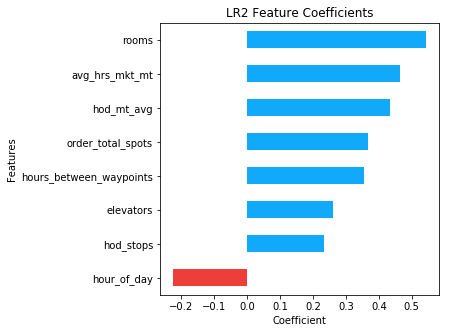

In [245]:
# Plotting Coefficients/Feature Importance
coeff = list(best_grid.coef_[0])

labels = list(X_train_lr2.columns)

features = pd.DataFrame()

features['Features'] = labels

features['importance'] = coeff

features.sort_values(by=['importance'], ascending=True, inplace=True)

features['positive'] = features['importance'] > 0

features.set_index('Features', inplace=True)

features.importance.plot(kind='barh', figsize=(5, 5),color = features.positive.map({True: "#11A9F9", False: "#EE3E3A"}))

plt.title('LR2 Feature Coefficients')
plt.xlabel('Coefficient')

plt.show()

In [246]:
features

,importance,positive
Features,,
hour_of_day,-0.225908,False
hod_stops,0.233438,True
elevators,0.261819,True
hours_between_waypoints,0.354424,True
order_total_spots,0.367978,True
hod_mt_avg,0.435103,True
avg_hrs_mkt_mt,0.463664,True
rooms,0.544340,True


## Random Forest Classifier

[This article](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) by William Koehrsen has been an extremely helpful resource for this section.

In [151]:
# Create a df with columns that are appropriate for random forest classification
df_rf = df_p
# Remove market dummies. (Logistic Regression analysis showed them to be of low importance.)
df_rf = df_rf.drop(market_dummies, axis = 1)
pprint(df_rf.columns.values)

array(['order_total_spots', 'fs', 'house', 'residence', 'rooms',
       'coupon_amount', 'grpn', 'dense', 'flights_of_stairs', 'stops',
       'elevators', 'additional_instructions', 'phone', 'city_pop',
       'pop_density', 'hours_between_waypoints', 'over', 'hour_of_day',
       'morning', 'day_of_week', 'weekend', 'lead_days', 'nb_months',
       'nb_days', 'mt_atob', 'mt_fs', 'mt_inhouselabor', 'mt_loading',
       'mt_unloading', 'second_stop', 'extra_stop', 'extra_hop',
       'web_extra_hop', 'extra_rooms', 'coupon', 'fs_dense', 'fs_rooms',
       'fs_stops', 'dense_apt', 'second_stop_extra_rooms',
       'second_stop_dense', 'second_stop_extra_rooms_dense',
       'house_rooms', 'rooms_stairs', 'rooms_stops', 'rooms_stops_square',
       'rooms_stairs_stops', 'rooms_squared', 'rooms_spots',
       'avg_hrs_mkt_mt', 'hod_mt_avg', 'hod_stops'], dtype=object)


In [152]:
#'Over' is the binary column that indicates whether or not the move went over the 3 hour mark
training_target_rf = df_rf.over
training_features_rf = df_rf.drop('over',axis = 1)

# Split the data into a training and test set.
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(training_features_rf, training_target_rf,
                                                  test_size = .1,
                                                  random_state = 42)

First, we will try a wide range of parameters using RandomizedSearchCV. We'll use those results to narrow the rang of paramters we'll use in a GridSearchCV.

In [153]:
# Specify wide ranges for each parameter and create random grid. The goal here is a to pick a wide range of parameters 
# so that the best version from this 
# Class weights (There are relatively few observations in the positive class, so we want to balance the classes.)
class_weight = ['balanced']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 50, 150, 200]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 10, 20, 50, 70, 100]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'class_weight': class_weight,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print('Parameter Grid')
pprint(random_grid)
print(' ')

# Use the random grid to search to find best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(scoring = 'f1', estimator = rf, param_distributions = random_grid, n_iter = 40, cv = 4, random_state=42, n_jobs = -1, verbose = 1)
# Fit the random search model
rf_random.fit(X_train_rf, y_train_rf)

print('Best Parameters')
pprint(rf_random.best_params_)
print('Best Score')
pprint(rf_random.best_score_)
print(' ')

print('Evaluating Random Search Model')
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_rf, y_test_rf)
print(' ')


Parameter Grid
{'bootstrap': [True, False],
 'class_weight': ['balanced'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 10, 20, 50, 70, 100],
 'min_samples_split': [2, 5, 10, 50, 150, 200],
 'n_estimators': [25, 77, 130, 183, 236, 288, 341, 394, 447, 500]}
 
Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.2min finished


Best Parameters
{'bootstrap': True,
 'class_weight': 'balanced',
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 50,
 'n_estimators': 447}
Best Score
0.6827383706178496
 
Evaluating Random Search Model

Model Performance
F1: 71.1
Accuracy: 77.1 %
Recall: 79.1 %
Precision: 64.6 %
Positive Predictions: 43.7 %
Positive Actuals: 35.7 %
False Negatives: 7.5 %
False Positives: 15.5 %
 


In [154]:
# Static version of best model for RF1
rf1 = RandomForestClassifier(class_weight = 'balanced', 
                             bootstrap = True, 
                             max_depth = 40, 
                             max_features = 'sqrt',
                             min_samples_leaf = 1,
                             min_samples_split = 50,
                             n_estimators = 447
                            )
#fit the best one
rf1.fit(X_train_rf, y_train_rf)

print('Evaluating Random Search Model')
random_accuracy = evaluate(rf1, X_test_rf, y_test_rf)
print(' ')

Evaluating Random Search Model

Model Performance
F1: 71.2
Accuracy: 77.2 %
Recall: 79.1 %
Precision: 64.8 %
Positive Predictions: 43.6 %
Positive Actuals: 35.7 %
False Negatives: 7.5 %
False Positives: 15.4 %
 


Feature ranking:
1. feature 49 (0.101072)
2. feature 15 (0.082407)
3. feature 35 (0.072633)
4. feature 48 (0.070642)
5. feature 28 (0.054496)
6. feature 9 (0.046263)
7. feature 36 (0.046177)
8. feature 44 (0.036174)
9. feature 43 (0.036085)
10. feature 47 (0.032405)
11. feature 1 (0.032278)
12. feature 24 (0.028307)
13. feature 20 (0.026601)
14. feature 22 (0.024900)
15. feature 21 (0.024502)
16. feature 14 (0.022685)
17. feature 50 (0.017853)
18. feature 30 (0.017374)
19. feature 0 (0.017332)
20. feature 38 (0.016284)
21. feature 46 (0.014755)
22. feature 45 (0.014526)
23. feature 13 (0.013328)
24. feature 4 (0.013198)
25. feature 5 (0.012825)
26. feature 16 (0.011414)
27. feature 10 (0.011185)
28. feature 41 (0.010591)
29. feature 18 (0.009552)
30. feature 42 (0.009480)
31. feature 8 (0.008981)
32. feature 32 (0.008960)
33. feature 31 (0.008695)
34. feature 11 (0.005110)
35. feature 12 (0.004842)
36. feature 2 (0.004788)
37. feature 27 (0.004501)
38. feature 3 (0.003947)
39. feature 

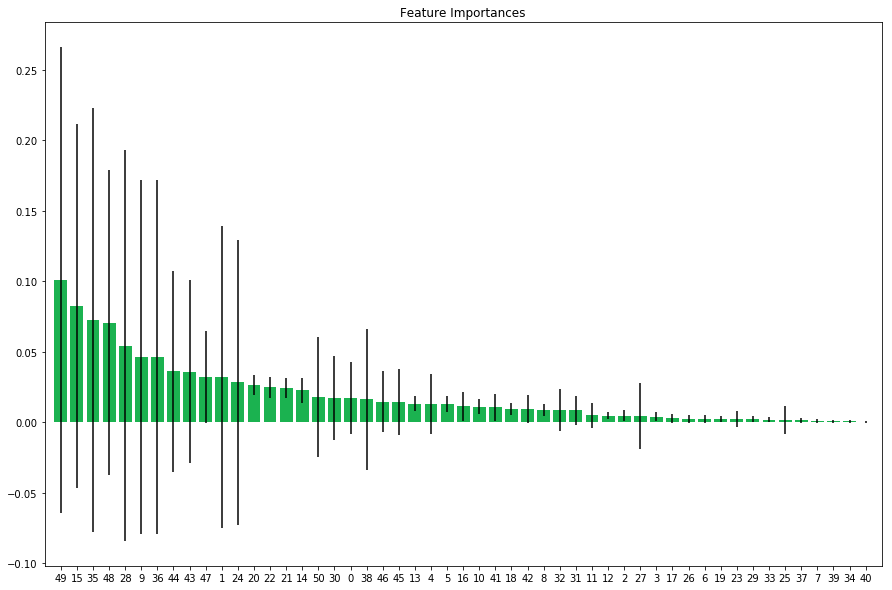

In [155]:
importances = rf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf1.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_test_rf.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature Importances")
plt.bar(range(X_test_rf.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X_test_rf.shape[1]), indices)
plt.xlim([-1, X_test_rf.shape[1]])
plt.show()

In [156]:
# Using Grid search to evaluate a narrower range of parameters centers on the best parameters from randomized search
param_grid = {
    'bootstrap': [True],
    'class_weight': ['balanced'],
    'max_depth': [50, 60, 70, 80, 90],
    'max_features': ['sqrt'],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [2],
    'n_estimators': [80, 100, 130, 150, 200, 250, 300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(scoring = 'f1', estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_rf, y_train_rf)

print(grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test_rf, y_test_rf)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 525 out of 525 | elapsed:  2.7min finished


{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}

Model Performance
F1: 68.5
Accuracy: 76.4 %
Recall: 71.6 %
Precision: 65.6 %
Positive Predictions: 39.0 %
Positive Actuals: 35.7 %
False Negatives: 10.1 %
False Positives: 13.4 %


In [178]:
# Static version of best model for RF2
rf2 = RandomForestClassifier(class_weight = 'balanced', 
                             bootstrap = True, 
                             max_depth = 50, 
                             max_features = 'sqrt',
                             min_samples_leaf = 15,
                             min_samples_split = 2,
                             n_estimators = 100
                            )
#fit the best one
rf2.fit(X_train_rf, y_train_rf)

print('Evaluating Random Search Model')
random_accuracy = evaluate(rf2, X_test_rf, y_test_rf)
print(' ')

Evaluating Random Search Model

Model Performance
F1: 71.4
Accuracy: 77.0 %
Recall: 80.4 %
Precision: 64.2 %
Positive Predictions: 44.7 %
Positive Actuals: 35.7 %
False Negatives: 7.0 %
False Positives: 16.0 %
 


In [236]:
# Combine predictions with the rest of the columns from df to evaluate potential solution strategies
predictions = rf2.predict(X_test_rf)
y_X_test_rf = X_test_rf.loc[:]
y_X_test_rf = y_X_test_rf.add_suffix('_test')
y_X_test_rf ['predictions'] = predictions
strat_eval = pd.concat([y_X_test_rf, df], axis=1, join='inner', verify_integrity=True)

# Add a column for what the estimated man hours would have been if another mover was on the job, 
# assuming reduces length proportionally
# strat_eval['over_with_add_mover_strat'] = np.where(strat_eval.predictions == 1 , np.where((strat_eval.actual_man_hours/(strat_eval.order_total_spots + 1))>3, 1, 0), strat_eval.over)
strat_eval['over_with_add_mover'] = np.where((strat_eval.actual_man_hours/(strat_eval.order_total_spots + 1))>3, 1, 0)
#strat_eval['over_with_add_mover_strat'] = np.where(strat_eval.predictions == 1 , np.where((strat_eval.actual_man_hours/np.ceil((strat_eval.booked_man_hours*1.5)/3))>3, 1, 0), strat_eval.over)

strat_eval['over_with_add_mover_strat'] = np.where(strat_eval.predictions == 1 , np.where((strat_eval.actual_man_hours/((strat_eval.booked_man_hours/3)+1))>3, 1, 0), strat_eval.over)

#strat_eval['over_with_add_mover_strat'] = np.where(strat_eval.predictions == 1 , np.where((strat_eval.actual_man_hours/((strat_eval.booked_man_hours/3)))>3, 1, 0), strat_eval.over)


resulting_over = np.mean(strat_eval.over_with_add_mover_strat)
over = np.mean(strat_eval.over)
runover_decrease = (resulting_over - over)/over
print('Percent Over: {:0.1f}'.format(round(over*100,1))+'% of moves that run over 3 hrs currently.')
print('Percent Over with Adding Hops: {:0.1f}'.format(round(resulting_over*100,1))+'% of moves that run over 3 hrs if assumed move was 150% booked man hours when predicted to run over.')
print('Run Over Decrease: {:0.1f}'.format(round(runover_decrease*100,1))+'%')


Percent Over: 35.7% of moves that run over 3 hrs currently.
Percent Over with Adding Hops: 15.4% of moves that run over 3 hrs if assumed move was 150% booked man hours when predicted to run over.
Run Over Decrease: -57.0%


In short, all of the models (with more than one feature) have very similar performance. All have an false negative rate between 6.5% and 7.5% and accuracy between 74% and 77%. (From the business perspective, the slight preference might be to implement the model with the lowest false negative rate.) With this model, Bellhops would not increase accuracy, but would reduce the false negative rate by almost 10 percentage points. If Bellhops used this model to predict which moves were going to run over the three hour threshold, Bellhops could simply assign more movers to those moves, thereby reducing average move lengths, increasing the number of moves per day, increasing contribution margin, and improving the customer experience. 